# Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Run](#2.-Run)
	* [2.1 Create test plasma](#2.1-Create-test-plasma)
	* [2.2 Initialize propagator](#2.2-Initialize-propagator)
	* [2.3 Generate incidental wave](#2.3-Generate-incidental-wave)
	* [2.4 Propagate](#2.4-Propagate)
* [3. Examine the result](#3.-Examine-the-result)
	* [3.1 O-mode case: weak absorption](#3.1-O-mode-case:-weak-absorption)
	* [3.2 X-mode case: Strong absorption](#3.2-X-mode-case:-Strong-absorption)
	* [3.3 3rd Harmonic Resonance, relativistic down shifted frequency](#3.3-3rd-Harmonic-Resonance,-relativistic-down-shifted-frequency)
* [4. 2D Propagator Demo](#4.-2D-Propagator-Demo)
	* [4.1 Benchmark with 1D propagator](#4.1-Benchmark-with-1D-propagator)
		* [4.1.1 Cold Plasma](#4.1.1-Cold-Plasma)
		* [4.1.2 Weakly Relativistic Plasma](#4.1.2-Weakly-Relativistic-Plasma)


<a id='top'></a>

# 1. Introduction

- `FPSDP.Models.Waves.Propagator` is developed to solve electromagnetic waves propagation problem in spatially varying plasmas. Currently, it has paraxial propagators for perpendicularly incidental waves in 1D or 2D plasma profiles. The dimensionality of plasma profile means that the relevant plasma parameters (dielectric tensor elements) are varying in this many spatial dimensions. For 1D model, plasma is only changing along *x* direction, which has been chosen to be the main propagation direction. 2D plasmas change along *y* direction as well. *z* direction is always assumed to be along magnetic field, thus no magnetic shear is considered. 

- Electric field of the wave is solved using paraxial approximation, i.e. $k_x \gg k_y,k_z$. So the total electric field is $$E(x,y,z) = E_0(x,y,z)\exp\left(\pm i\int^x k_x(x')dx'\right)$$, where $E_0$ is called the amplitude, and $k_x$ the main wave vector. The wave equation is then solved order by order.  

- `FPSDP.Plasma.DielectricTensor` provides several kinds of plasma dielectric tensors. 
  - `FPSDP.Plasma.DielectricTensor.ColdElectronColdIon` is the simplest model which uses cold fluid model for both electrons and ions. 
  - `FPSDP.Plasma.DielectricTensor.WarmElectronColdIon` is slightly more complex. It includes the parallel electron's pressure, which leads to a temperature correction in zz-component of the dielectric tensor. Optional cold ions
  - `FPSDP.Plasma.DielectricTensor.HotElectronColdIon`: Electron susceptibility is using expression derived from Vlasov-Maxwell equations. The non-relativistic limit is used, so a finite $k_z$ is required. Equilibirum velocity distribution is assumed to be Maxwellian, but not necessarily isotropic. Optional cold ions.
  - `FPSDP.Plasma.DielectricTensor.RelElectronColdIon`: Weakly relativistic electrons are used. However, we require isotropic Maxwellian distribution in this case. Both $k_z$ and $k_x$ are required. Optional cold ions.

- Incidental wave patterns can be generated using classes in `FPSDP.Maths.LightBeam`. Currently, only Gaussian beams are provided.
  - `FPSDP.Maths.LightBeam.GaussianBeam` is initialized with the following parameters:
    ```
    :param float wave_length: the wave length :math:`\lambda`
    :param float waist_x: The x' coordinate of waist location in Lab frame
    :param float waist_y: The y' coordinate of waist location in Lab frame 
    :param float waist_z: The z' coordinate of waist location in Lab frame
                          (Optional, Default to be 0)  
    :param float tilt_v: the tilt-angle in vertical plane in radian. 0 is 
                         defined as along negative x' axis, and tilt_y>0 if 
                         the beam is tilted upwards, i.e. towards positive 
                         y' direction.
                         (Optional, Default to be 0)
    :param float tilt_h: the tilt-angle in x'-z' plane in radian. 0 is defined 
                         as along negative x' axis, and tilt_z>0 if the beam
                         is tilted upwards, i.e. towards positive z' direction
                         (Optional, Default to be 0)
    :param float rotation: (Optional Default to be 0) 
                           the rotated angle of the elliptic Gaussian. It is 
                           defined as the angle between local y axis and lab y'
                           axis if local z axis has been rotated to align with
                           lab -x' axis. This angle is the tilted angle of the
                           ellipse in the transvers plane. 
    :param float w_0y: waist width in the vertical-like direction (eventually 
                       aligns with y' axis)
    :param float w_0z: waist width in the horizontal-like direction (eventually
                       aligns with z' axis) (Optional, default to be same as 
                       w_0y)  
    :param complex E0: The complex amplitude at beam frame origin
                       (Optional, default is 1)
    :param float P_total: The total power of the beam. Optional, if given, *E0*
                          argument will be ignored. The amplitude of the beam
                          will be determined by P_total. 
    ```
  - The `GaussianBeam` object is callable, calling it with a set of coordinates will return beam's electric field at these coordinates.

[top](#top)

<a id='section2'></a>

# 2. Run

<a id='section2.1'></a>

## 2.1 Create test plasma

Now we'll set up a scenario and demostrate the use of these packages. First, we import all the useful modules and prepare the test plasma.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
%matplotlib inline

import FPSDP.Plasma.Analytical_Profiles.TestParameter as tp
import FPSDP.Maths.LightBeam as lb
import FPSDP.Models.Waves.Propagator as prop
import FPSDP.Plasma.DielectricTensor as dt
from FPSDP.GeneralSettings.UnitSystem import cgs

pylab.rcParams['figure.figsize'] = (10.0, 8.0)
pylab.rcParams['font.size'] = 20

tp.set_parameter1D(Te_0=10*cgs['keV'])
p1d = tp.create_profile1D(True, 0)
p1d.setup_interps()

A purely random fluctuation can be generated at each location if the first parameter of `create_profile1D` function is True, with the relative amplitude set in the second paramter, which is 0 here.

Let us take a look at the profile we created. It is a very simple linear profile just for test use. 

In [2]:
print p1d

Electron Cyclotron Emission Imaging Plasma Profile:

Unit System:cgs
Length: centi-meter
Mass: gram
Time: second

Grid:1D Cartesian Grids
Xmin :150
Xmax :300
NX,ResX :(301, 0.4983388704318937)

Physical Quantities:
Equilibrium:
    Electron density: ne0
    Electron temperature: Te0
    Magnetic field: B0
Fluctuation:
    Electron density: dne
    Electron parallel temperature: dTe_para
    Electron perpendicular temperature: dTe_perp
    Magnetic field magnitude: dB




Note that we only have electron profiles, so no ions will be added. Since we are gonna use waves with electron cyclotron frequency range, we don't expect ions contribute much to the dielectric tensor. 

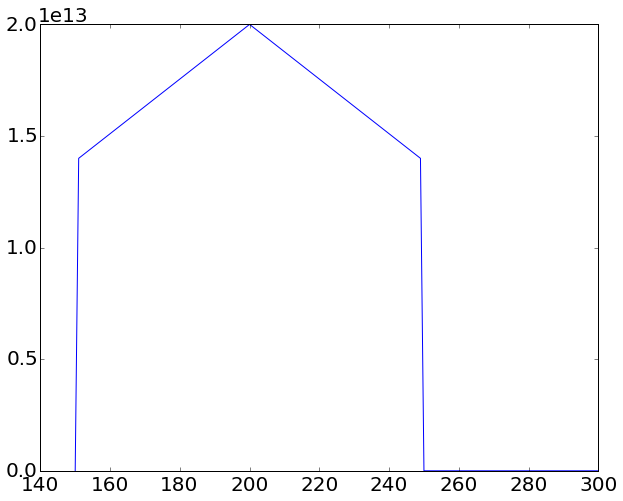

In [3]:
plt.plot(p1d.grid.X1D, p1d.ne0)

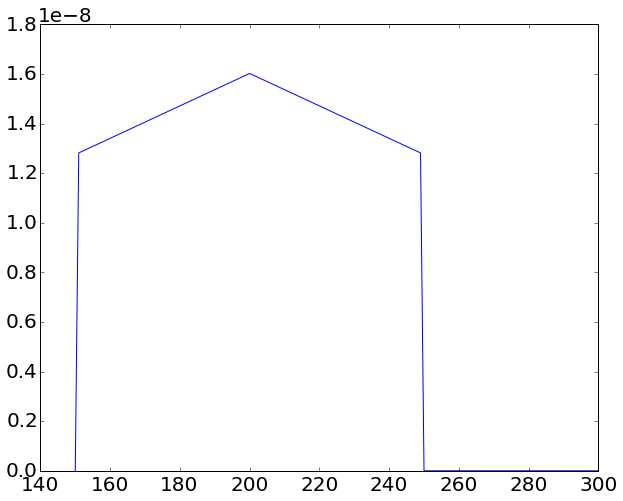

In [4]:
plt.plot(p1d.grid.X1D, p1d.Te0)

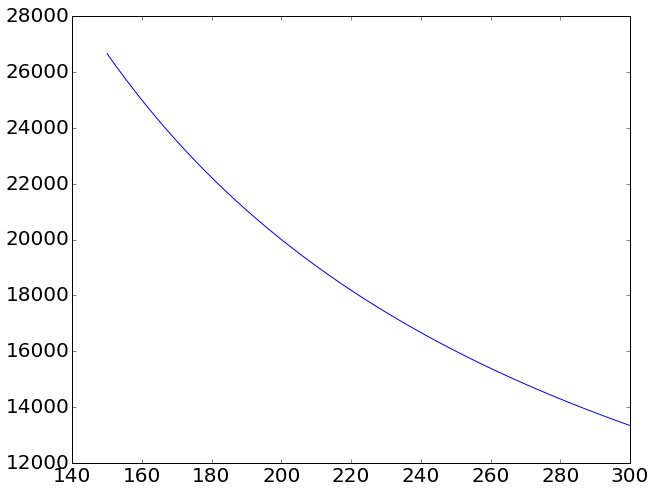

In [5]:
plt.plot(p1d.grid.X1D, p1d.B0)

Note that all quantities are in Gaussian unit, and temperature has a unit of energy, which is erg. 

[top](#top)

<a id='section2.2'></a>

## 2.2 Initialize propagator

In [2]:
propagator1d = prop.ParaxialPerpendicularPropagator1D(plasma = p1d, 
                                                      dielectric_class = dt.RelElectronColdIon, 
                                                      polarization = 'O', 
                                                      direction = -1,
                                                      max_harmonic = 2,
                                                      max_power = 2)

Propagator 1D initialized.


A detailed description can be found in the docstring of the class. 
Several remarks:
- dielectric_class: In addition to the models mentioned before, one can create any kind of dielectric models based on the existing susceptibility models.
- polarization: either 'O' or 'X'. We solve the propagation based on the 0th order solution of a purely perpendicular cold plasma wave, it has two branches, which are refered to as 'O-mode' and 'X-mode'.
- direction: either 1 or -1. 1 means propagate along positive x direction, -1 means along negative x direction.
- max\_harmonic and max\_power: these are parameters only used in hot plasma models. max\_harmonic controls the highest harmonic number included in dielectric tensor. max\_power determines up to which power of $\lambda \equiv k_\perp^2\rho_e^2$ terms are kept. 

[top](#top)

<a id='section2.3'></a>

## 2.3 Generate incidental wave

In [11]:
y_min, y_max = -20, 20
z_min, z_max = -20, 20
ny = 64
nz = 64
start_plane = tp.Grid.Cartesian2D(DownLeft=(z_min,y_min), UpRight=(z_max,y_max), 
                                  NR=ny, NZ=nz)
x_start = 250
x_end = 150
nx = 100

Z2D,Y2D = start_plane.get_ndmesh()            
X2D = np.ones_like(Y2D)*x_start

omega = 8e11
wave_length = 2*np.pi*3e10/omega
gb = lb.GaussianBeam(wave_length, waist_x=280, waist_y=0, w_0y=3, tilt_h=np.pi/36, P_total=1)

E_start = gb([Z2D, Y2D, X2D])

Z1D, Y1D = start_plane.get_mesh()

- The incidental electric field must be on a regular uniformly spaced 2D mesh. A easy way to create the mesh is through `FPSDP.Geometry.Grid.Cartesian2D` class, and then use its `get_ndmesh()` method. Note that the default order of coordinates is (Z,R). 
- The `X2D` coordinates is needed because `GaussianBeam` assumes unstructured points in 3D space, a 2D plane of y-z will have all the same x-coordinate. 
- `x_start, x_end, nx` are used in propagating function. They determines the range of propagation and the steps in x.
- `Z1D, Y1D` are needed when pass the incidental field into the propagator, since a structured mesh is required, only 1D arrays are needed. 

[top](#top)

<a id='section2.4'></a>

## 2.4 Propagate

In [12]:
E = propagator1d.propagate(omega, x_start, x_end, nx, E_start, 
                         Y1D, Z1D, time=0, mute=False)

Epsilon0 generated. Time used: 0.000462s
k0, ky, kz generated. Time used: 0.000708s
Delta_epsilon generated.Time used: 1.14s
Polarization eigen-vector generated. Time used: 2.2e-06s
F function calculated. Time used: 0.0987s
E field calculated. Time used: 0.0422s
1D Propogation Finish! Check the returned E field. More infomation is available in Propagator object.
Total Time used: 1.28s



- Propagate function requires the following arguments:
  - `omega`: the frequency of the wave
  - `x_start, x_end, nx`: the start, end coordinates in x, and it will be devided into `nx` increments, so total `nx+1` grid points. Alternatively, a keyword argument `x_coords` is acceptable, it should be a 1D array of x coordinates monotonically increasing or decreasing, doesn't need to be uniform.
  - `E_start, Y1D, Z1D`: the incidental wave field, 2D complex array, and the Y, Z, coordinates associated with it. The array should be in the shape (NZ, NY).
  - `time`: Optional, int, specify the time step in plasma fluctuation data to use. If not given, only equilibrium plasma is used.
- The return value is the electric field on 3D mesh. The Y-Z mesh extended along x direction as determined by `x_start, x_end, nx` or `x_coords`. The shape will be (NZ, NY, NX).
- In addition to the wave field, more information about the propagation process can be found in `propagator1d` object. 

[top](#top)

<a id='section3'></a>

# 3. Examine the result

<a id='section3.1'></a>

## 3.1 O-mode case: weak absorption

First, let's take a look at the electric field.

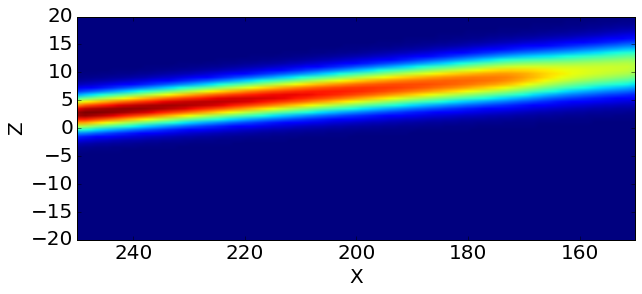

In [13]:
plt.imshow(np.abs(E[:,ny/2,:]), extent=[x_start, x_end, z_min, z_max], origin='lower')
plt.xlabel('X')
plt.ylabel('Z')

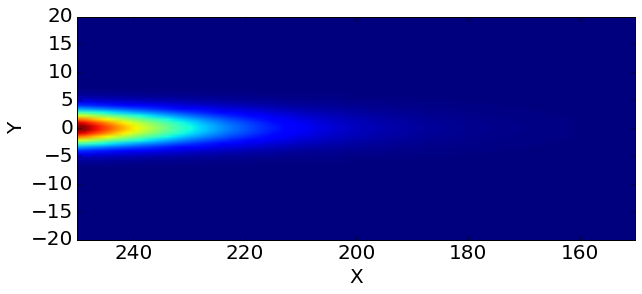

In [15]:
plt.imshow(np.abs(E[nz/2,:,:]), extent=[x_start, x_end, z_min, z_max], origin='lower')
plt.xlabel('X')
plt.ylabel('Y')

Since we generated a Gaussian beam focussing at x=280, y=0, z=0 (0 was the default value for `waist_z`), propagating at 5 degree tilted horizontally, with a waist width of 3cm. The propagation result looks reasonable. We can quickly check the divergence of the beam using the properties provided in GaussianBeam:

In [11]:
gb.reighlay_range

(120.00000000000001, 120.00000000000001)

In [12]:
gb.divergence

(0.024999999999999998, 0.024999999999999998)

An interesting phenomenon we see above, is that the wave amplitude decays at the very end of the propagation range. This is due to the 2nd harmonic electron cyclotron resonance. We can check this is indeed happening by ploting the summed amplitude of the wave along central Y:(In order to plot along negative x direction, we set $x=-x$)

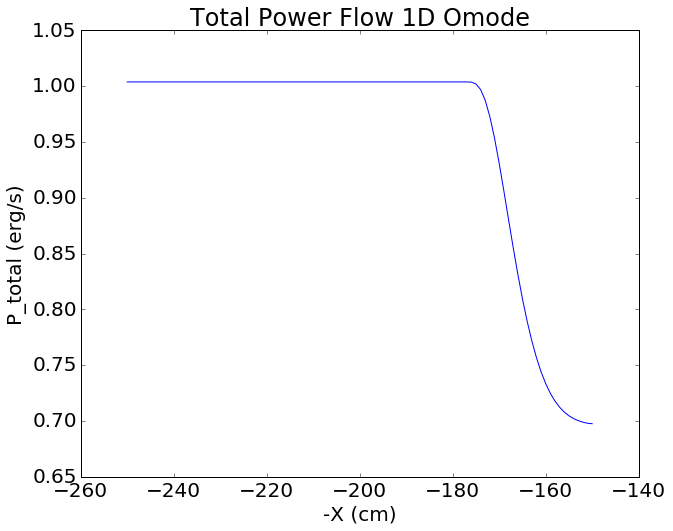

In [27]:
X1D = -propagator1d.x_coords
plt.plot(X1D, np.abs(propagator1d.power_flow))
plt.title('Total Power Flow 1D Omode')
plt.ylabel('P_total (erg/s)')
plt.xlabel('-X (cm)')

We can also check the anti-Hermitian part of the dielectric tensor, the relevant element is $\epsilon_{zz}$.

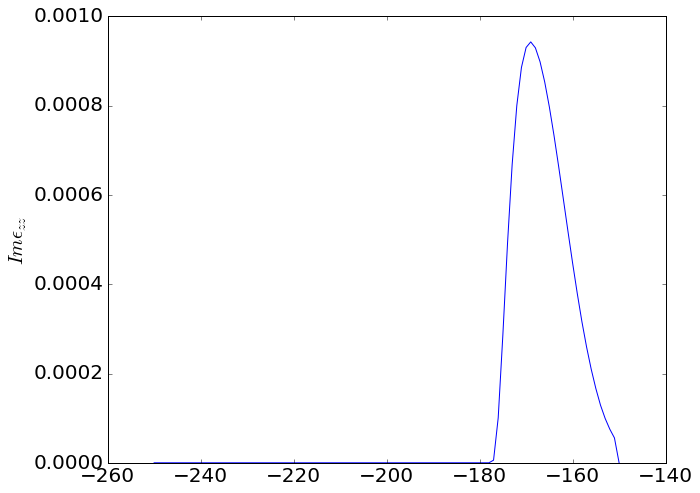

In [19]:
plt.plot(X1D, np.imag(propagator1d.deps[2,2,28,0,:]))
plt.ylabel('$Im\epsilon_{zz}$')

Let's also check this happens at the second harmonic resonance location.

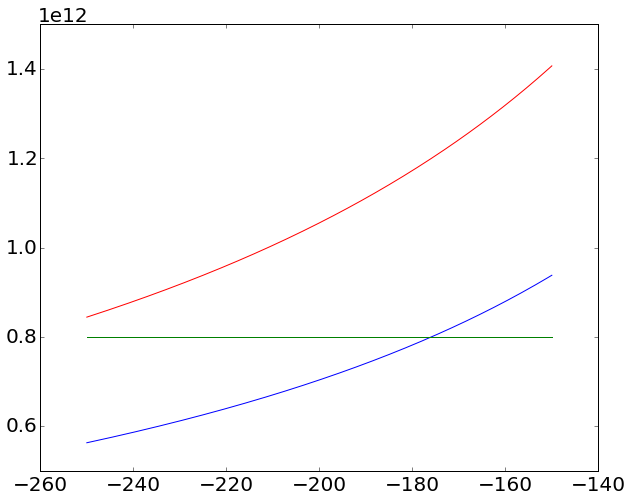

In [15]:
x_coords = propagator1d.x_coords
B = p1d.get_B([x_coords])
c = cgs['c']
me = cgs['m_e']
e = cgs['e']

omega_c = e*B/(me*c)

plt.plot(X1D, 2*omega_c)
plt.plot(X1D, np.ones_like(X1D)*omega)
plt.plot(X1D, 3*omega_c)

The cross point between blue and green line is the cold 2nd harmonic resonance, we can see that it is exactly where the absorption starts. We also plot the 3rd harmonic for later reference. It can be seen that at the edge, the 3rd harmonic is pretty close to our frequency, relativistic down shift effects may actually cause 3rd harmonic resonance to happen there. We will check that later. First, let's try the X mode.  

[top](#top)

<a id='section3.2'></a>

## 3.2 X-mode case: Strong absorption

If we look at other components of the dielectric tensor, we will see that X mode may have a much stronger absorption.

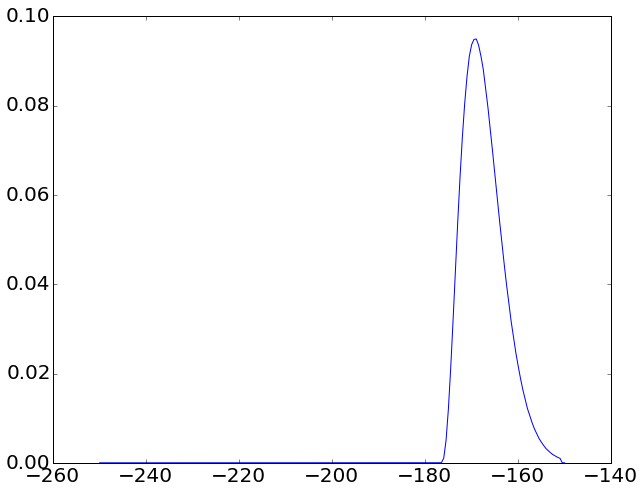

In [16]:
plt.plot(X1D, np.imag(propagator1d.deps[0,0,28,0,:]))

The amplitude is 100 times larger than that in O mode.

Then, let's have a try. The only thing we need to do, is create a new propagator for X mode.

In [21]:
propagator1dX = prop.ParaxialPerpendicularPropagator1D(plasma = p1d, 
                                                      dielectric_class = dt.RelElectronColdIon, 
                                                      polarization = 'X', 
                                                      direction = -1,
                                                      max_harmonic = 2,
                                                      max_power = 2)

Propagator 1D initialized.


In [22]:
E_X = propagator1dX.propagate(omega, x_start, x_end, nx, E_start, Y1D, Z1D, time=0, mute=False)

Epsilon0 generated. Time used: 0.000788s
k0, ky, kz generated. Time used: 0.00107s
Delta_epsilon generated.Time used: 1.15s
Polarization eigen-vector generated. Time used: 4.66e-05s
F function calculated. Time used: 0.112s
E field calculated. Time used: 0.0454s
1D Propogation Finish! Check the returned E field. More infomation is available in Propagator object.
Total Time used: 1.31s



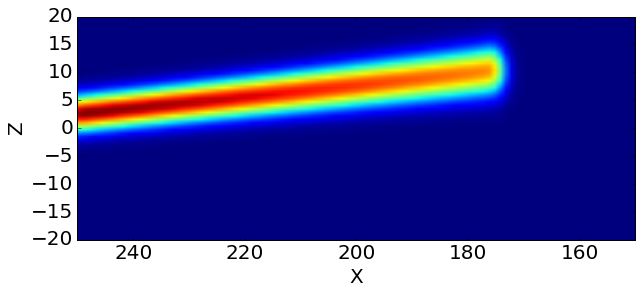

In [23]:
plt.imshow(np.abs(E_X[:,ny/2,:]), extent=[x_start, x_end, z_min, z_max], origin='lower')
plt.xlabel('X')
plt.ylabel('Z')

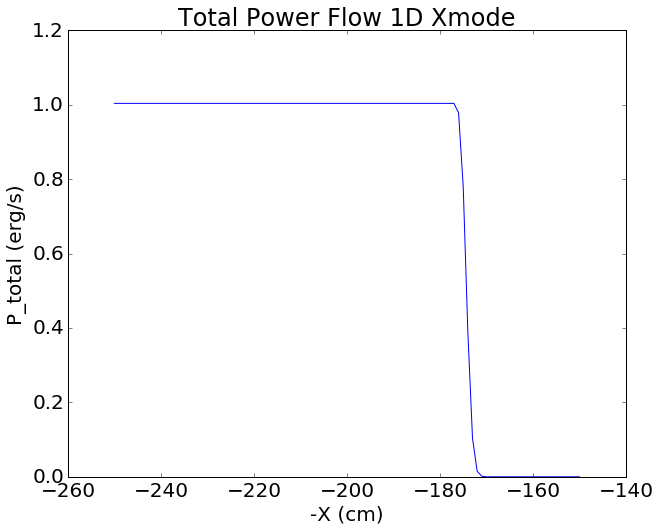

In [26]:
plt.plot(X1D, np.abs(propagator1dX.power_flow))
plt.title('Total Power Flow 1D Xmode')
plt.ylabel('P_total (erg/s)')
plt.xlabel('-X (cm)')

As we can see, the wave gets absorbed completely in several centimeters. 

[top](#top)

<a id='section3.3'></a>

## 3.3 3rd Harmonic Resonance, relativistic down shifted frequency

As we see in the frequency plot, 3rd harmonic frequency is very close to our wave frequency at the very beginning part of the propagation. The model we used above didn't include the 3rd harmonic effects because we set `max_harmonic` paramter to 2. Now, let's try to investigate the 3rd harmonic effects.

First, create a propagator with higher harmonics enabled. 

> Note that right now, the dielectric tensor elements are evaluated from its original formula in real time. This involves evaluating the weakly relativistic plasma dispersion function $\mathcal{F}_q(\phi,\psi)$ a lot of times. The total evaluation complexity goes roughly as $n^3$, with n being the maximum harmonic. So, going above n=3 will be **very** time consuming. An optimization will be applied to this issue. A pre-calculated look-up table will be used for interpolation.  

In [28]:
propagator1dX_3 = prop.ParaxialPerpendicularPropagator1D(plasma = p1d, 
                                                      dielectric_class = dt.RelElectronColdIon, 
                                                      polarization = 'X', 
                                                      direction = -1,
                                                      max_harmonic = 3,
                                                      max_power = 3)

Propagator 1D initialized.


> Another note about the `max_power` parameter. Right now, since the lowest order $\lambda$ in zz component for n-th harmonic is n. So `max_power` is required to be larger than `max_harmonic`. If it's given a smaller value, it will be automatically changed to `max_harmonic`. However, this might not be the desired behavior. Because, for X modes, zz-component doesn't play a very important role, and in xx, xy, and yy components, the leading order is actually n-1. So, it might be useful to allow user to set `max_power` = `max_harmonic`-1 for X mode propagations.

In [29]:
EX_3 = propagator1dX_3.propagate(omega, x_start, x_end, nx, E_start, Y1D, Z1D, time=0, mute=False)

Epsilon0 generated. Time used: 0.00064s
k0, ky, kz generated. Time used: 0.00239s
Delta_epsilon generated.Time used: 1.85s
Polarization eigen-vector generated. Time used: 4.44e-05s
F function calculated. Time used: 0.12s
E field calculated. Time used: 0.0426s
1D Propogation Finish! Check the returned E field. More infomation is available in Propagator object.
Total Time used: 2.02s



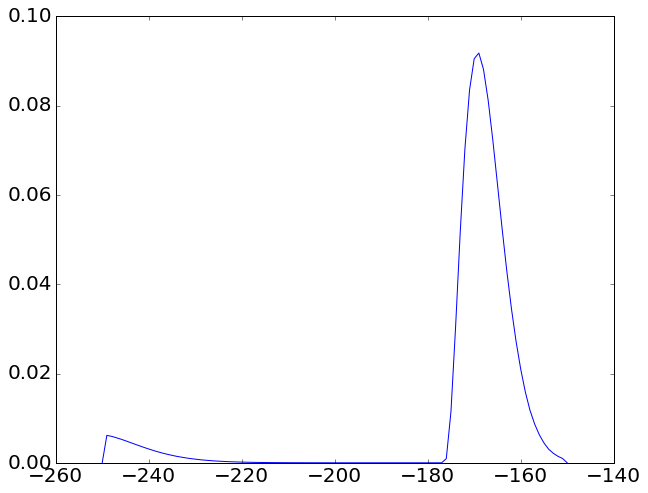

In [33]:
kz_max_idx = int(80.0*nz*28/((z_max-z_min)*256))
plt.plot(X1D, np.imag(propagator1dX_3.deps[0,0,kz_max_idx,0,:]))

We can indeed see a small tail of 3rd order harmonic resonance extended in our propagation range.

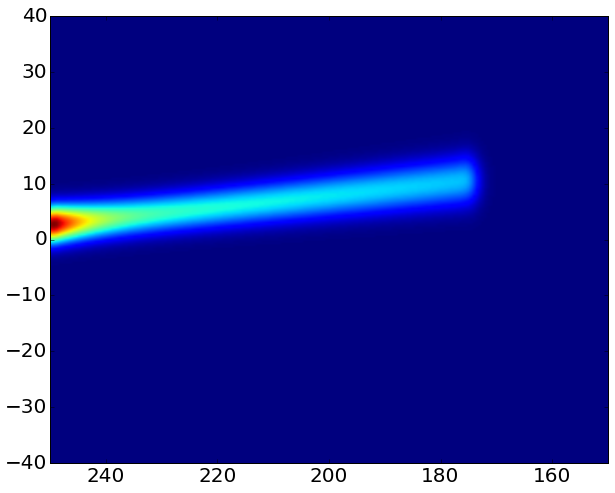

In [24]:
plt.imshow(np.abs(EX_3[:,127,:]), extent=[x_start, x_end, z_min, z_max], origin='lower')

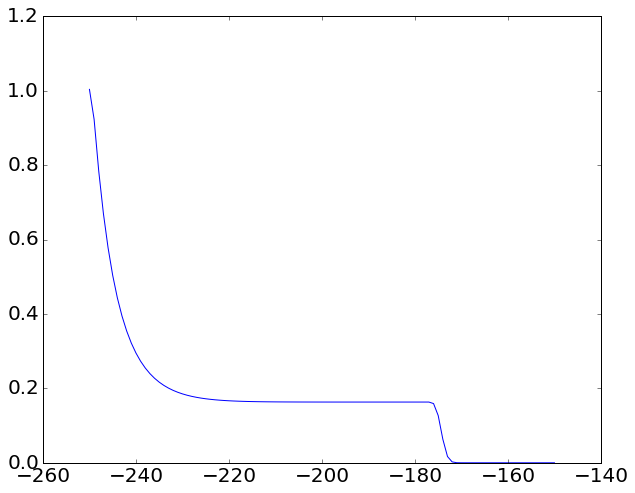

In [34]:
plt.plot(X1D, np.abs(propagator1dX_3.power_flow))

It indeed has a large impact on our wave. Almost half of the energy has been absorbed through the 3rd harmonic resonance. This is also bad for locality of ECEI measurements. 

[top](#top)

<a id='section4'></a>

# 4. 2D Propagator Demo

<a id='section4.1'></a>

## 4.1 Benchmark with 1D propagator

Now, we move on to use the 2D paraxial propagator. First, let's run a benchmark case and show that 2D propagator can recover 1D result in a 1D plasma.

In [26]:
import FPSDP.Plasma.Analytical_Profiles.TestParameter as tp
from FPSDP.Maths.LightBeam import GaussianBeam as gb

tp.set_parameter1D(Te_0=10*cgs['keV'])
tp.set_parameter2D(Te_0=10*cgs['keV'])

y_min = -10
y_max = 10
ny = 65
z_min = -10
z_max = 10
nz = 64

start_plane = tp.Grid.Cartesian2D(DownLeft=(z_min, y_min), UpRight=(z_max, y_max), 
                                  NR=ny, NZ=nz)
x_start = 250
x_end = 150
nx = 100

Z1D, Y1D = start_plane.get_mesh()
Z2D,Y2D = start_plane.get_ndmesh()            
X2D = np.ones_like(Y2D)*x_start

omega = 8e11

# In order see the diffraction effacts in y direction more clearly, we 
# intentionally use a strongly diverging beam, and do not tilt the beam
# in z direction this time.
gb = lb.GaussianBeam(2*np.pi*3e10/omega, 260, 0, 1, tilt_h=0, P_total=1)

E_start = gb([Z2D, Y2D, X2D])

Note that we use a strongly diverging beam here to exagerate the diffraction effect in y direction.

In [27]:
gb.reighlay_range, gb.divergence

((13.333333333333336, 13.333333333333336), (0.075, 0.075))

In order to do the benchmark, we need a 1D plasma on 2D mesh. This can be done by calling `FPSDP.Plasma.Analytical_Profiles.TestParameter.simulate_1D` function. This function receives 2 parameters, first a 1D plasma profile, second a 2D Grid. Then, the function will generate plasma quantities on the 2D grid using the given 1D data. Plamsa will be uniform along the extra dimension.

In [28]:
p1d = tp.create_profile1D(True, 0)
p1d.setup_interps()
grid2d = tp.Grid.Cartesian2D(DownLeft=(-60, 150), UpRight=(60, 300), NR=301, NZ=193)
p2d_sim = tp.simulate_1D(p1d, grid2d)
p2d_sim.setup_interps()

### 4.1.1 Cold Plasma

First, let's take a look at cold plasma results.

Initializing a 2D propagator is almost the same as initializing a 1D one. Only one additional parameter is needed: `ray_y`. This parameter specifies the `y` value of the estimated center of ray. The code will take cold dielectric along this central ray as the zeroth order dielectric tensor. 

In [29]:
propagator1d = prop.ParaxialPerpendicularPropagator1D(p1d, 
                                                      dt.ColdElectronColdIon, 
                                                      'X', 
                                                      direction=-1)
propagator2d_uni = prop.ParaxialPerpendicularPropagator2D(p2d_sim, 
                                                      dt.ColdElectronColdIon,
                                                      'X',
                                                      direction=-1,
                                                      ray_y=0)

Propagator 1D initialized.
Propagator 2D initialized.


In [30]:
E1 = propagator1d.propagate(omega, x_start, x_end, nx, E_start, 
                            Y1D, Z1D, mute=False)

Epsilon0 generated. Time used: 0.000913s
k0, ky, kz generated. Time used: 0.00159s
Delta_epsilon generated.Time used: 0.0351s
Polarization eigen-vector generated. Time used: 2.93e-05s
F function calculated. Time used: 0.0587s
E field calculated. Time used: 0.0268s
1D Propogation Finish! Check the returned E field. More infomation is available in Propagator object.
Total Time used: 0.125s



In [31]:
E2_uni = propagator2d_uni.propagate(omega, x_start, x_end, nx, E_start, 
                             Y1D, Z1D, mute=False)

Epsilon0 generated. Time used: 0.000614
k0, kz generated. Time used: 0.000306
Delta epsilon generated. Time used: 0.161
Polarization eigen-vector generated. Time used: 3.3e-05
F field calculated. Time used: 0.133
E field calculated. Time used: 0.0394
2D Propagation Finish! Check the returned E field. More infomation is available in Propagator object. Total time used: 0.335


<matplotlib.colorbar.Colorbar instance at 0x000000001F6342C8>

C:\Users\lei\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


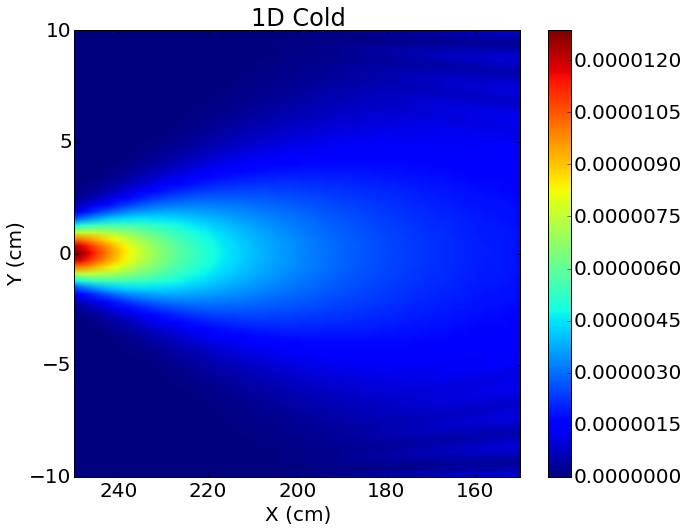

In [32]:
plt.figure()
plt.imshow(np.abs(E1[nz/2, :, :]), extent=[x_start, x_end, y_min, y_max], origin='lower', 
           aspect=np.abs((x_end-x_start)/(y_max-y_min)))
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.title('1D Cold')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x000000001F653208>

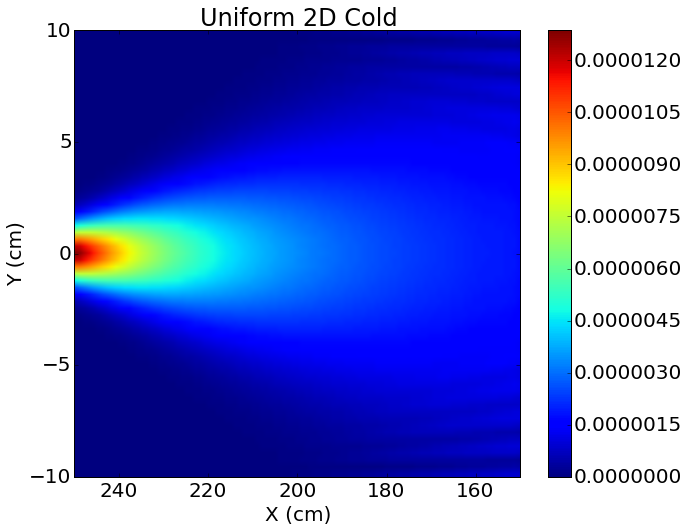

In [33]:
plt.figure()
plt.imshow(np.abs(E2_uni[nz/2, :, :]), extent=[x_start, x_end, y_min, y_max], origin='lower', 
           aspect=np.abs((x_end-x_start)/(y_max-y_min)))
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.title('Uniform 2D Cold')
plt.colorbar()

> Several remarks:
- We intentionally chose a beam that is diverging strongly. The Reighlay Length is 13.33cm. 
- Be careful with diverging beams. If the beam touches the upper or lower boundary, we may see interferance patterns as shown above. These are artificial result because we used Fourier Transform to evolve `k_y` related phase terms, this approach essentially assumed periodic boundary condition on y direction. So, for strongly diverging beams, the "phantom" beams from adjacent regions may come into our calculation area and create these interferance patterns. We need to enlarge the calculation range to eliminate them.

From the benchmark point of view, 2D result is in good agreement with the 1D result. The absolute and relative error can be calculated:

In [34]:
abs_err = E2_uni - E1
# we choose where E1 is larger than 0.001 of its maximum value to calculate the relative error, so we don't
# need to worry about dividing zero problem.
rel_idx = np.abs(E1)>1e-3*np.max(np.abs(E1))
rel_err = abs_err[rel_idx]/np.abs(E1[rel_idx])
print('max |E|: {}\nmax absolute error: {}\nmax relative error: {}'.format(np.max(np.abs(E1)), 
                                                                           np.max(np.abs(abs_err)), 
                                                                           np.max(np.abs(rel_err))) )

max |E|: 1.28594805106e-05
max absolute error: 6.38859786456e-10
max relative error: 0.000540615703526


This error is due to different step size in `x` when integrating main phase $\int^x k_0(x')dx'$. 2D propagator has an `x` grid twice as dense as the 1D propagator, because internally, it separates each step into two steps to evolve phase due to `y` direction inhomogeneity and `k_y` diffraction. 

A benchmark function `benchmark_1d2d` is contained in `FPSDP.scripts.unit_tests.test_Propagator` to track the absolute and relative error between 1D and 2D propagator results as a function of step size in `x`. 

In [35]:
from FPSDP.scripts.unit_tests.test_Propagator import benchmark_1d2d
abs_err_c, rel_err_c, nx_array_c, x_stepsize_c = benchmark_1d2d(nx_power_min=3, nx_power_max=10, nx_step=1, mode='X')

Propagator 1D initialized.
Propagator 2D initialized.
Total time: 12.54s


We can then plot the absolute error and relative error as function of step size in `x`. Here, we plot them in logrithm scales and provide the linear regression results.

In [36]:
from scipy.stats import linregress
slope_abs_c, intercept_abs_c, r_abs_c, p_abs_c, stderr_abs_c = linregress(np.log(x_stepsize_c), np.log(abs_err_c))
y_abs_c = np.exp(intercept_abs_c) * x_stepsize_c**slope_abs_c
slope_rel_c, intercept_rel_c, r_rel_c, p_rel_c, stderr_rel_c = linregress(np.log(x_stepsize_c), np.log(rel_err_c))
y_rel_c = np.exp(intercept_rel_c) * x_stepsize_c**slope_rel_c

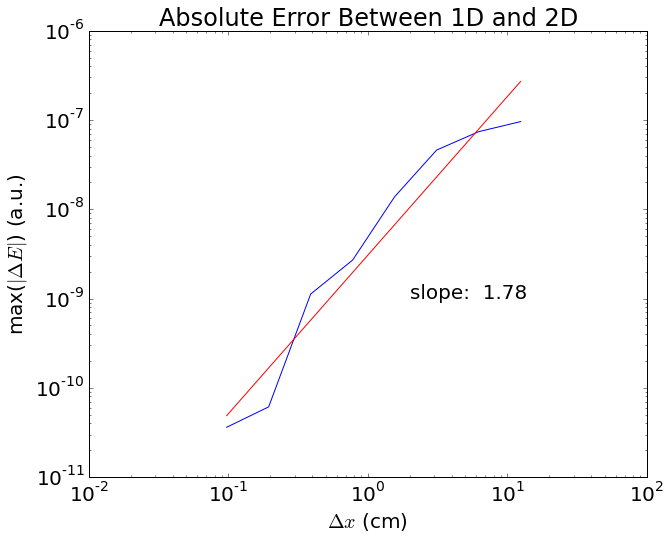

In [37]:
plt.figure()
plt.loglog(x_stepsize_c, abs_err_c)
plt.loglog(x_stepsize_c, y_abs_c, 'r-')
plt.xlabel('$\Delta x$ (cm)')
plt.ylabel('max($|\Delta E|$) (a.u.)')
plt.title('Absolute Error Between 1D and 2D')
plt.text(2, 1e-9, 'slope:  {:.3}'.format(slope_abs_c))

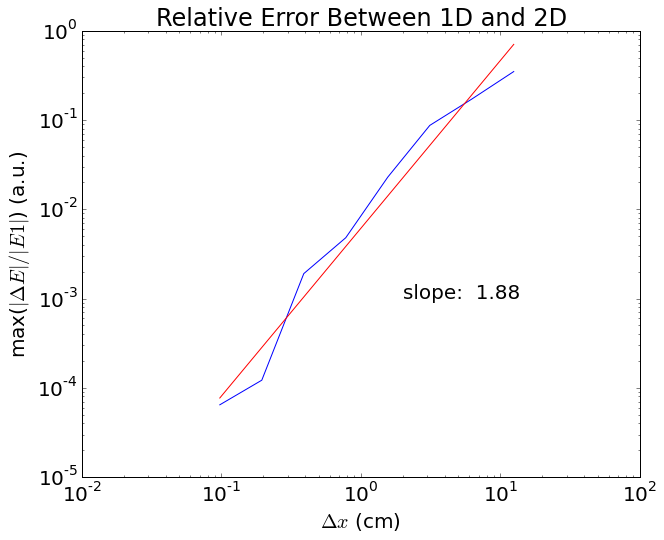

In [38]:
plt.figure()
plt.loglog(x_stepsize_c, rel_err_c)
plt.loglog(x_stepsize_c, y_rel_c, 'r-')
plt.xlabel('$\Delta x$ (cm)')
plt.ylabel('max($|\Delta E|/|E1|$) (a.u.)')
plt.title('Relative Error Between 1D and 2D')
plt.text(2, 1e-3, 'slope:  {:.3}'.format(slope_rel_c))

The absolute error and relative error both go roughly as $o(\Delta x^2)$ as we expected. This is a good sign of consistency between our 1D and 2D propagator results.

### 4.1.2 Weakly Relativistic Plasma

Similarly, we'll quickly show benchmark results using relativistic dielectric tensors.

In [39]:
propagator1d_r = prop.ParaxialPerpendicularPropagator1D(p1d, 
                                                       dt.RelElectronColdIon, 
                                                       'X', 
                                                       direction=-1,
                                                       max_harmonic=2,
                                                       max_power=2)
propagator2d_r_uni = prop.ParaxialPerpendicularPropagator2D(p2d_sim, 
                                                           dt.RelElectronColdIon,
                                                           'X',
                                                           direction=-1,
                                                           ray_y=0,
                                                           max_harmonic=2,
                                                           max_power=2)

Propagator 1D initialized.
Propagator 2D initialized.


In [40]:
E1_r = propagator1d_r.propagate(omega, x_start, x_end, nx, E_start, 
                            Y1D, Z1D, mute=False)

Epsilon0 generated. Time used: 0.000456s
k0, ky, kz generated. Time used: 0.000505s
Delta_epsilon generated.Time used: 0.528s
Polarization eigen-vector generated. Time used: 2.53e-05s
F function calculated. Time used: 0.0612s
E field calculated. Time used: 0.0272s
1D Propogation Finish! Check the returned E field. More infomation is available in Propagator object.
Total Time used: 0.619s



In [41]:
E2_r_uni = propagator2d_r_uni.propagate(omega, x_start, x_end, nx, E_start, 
                             Y1D, Z1D, mute=False)

Epsilon0 generated. Time used: 0.00068
k0, kz generated. Time used: 0.000358
Delta epsilon generated. Time used: 4.71
Polarization eigen-vector generated. Time used: 2.96e-05
F field calculated. Time used: 0.13
E field calculated. Time used: 0.04
2D Propagation Finish! Check the returned E field. More infomation is available in Propagator object. Total time used: 4.88


<matplotlib.colorbar.Colorbar instance at 0x000000003126B708>

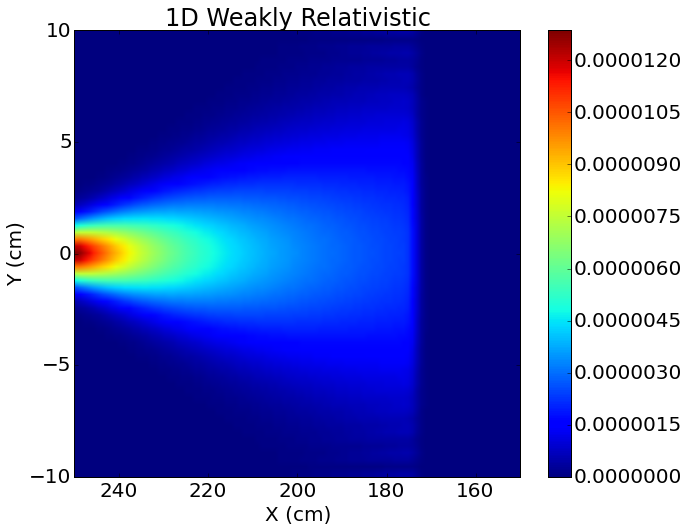

In [42]:
plt.figure()
plt.imshow(np.abs(E1_r[nz/2, :, :]), extent=[x_start, x_end, y_min, y_max], origin='lower', 
           aspect=np.abs((x_end-x_start)/(y_max-y_min)))
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.title('1D Weakly Relativistic')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x00000000316DFB08>

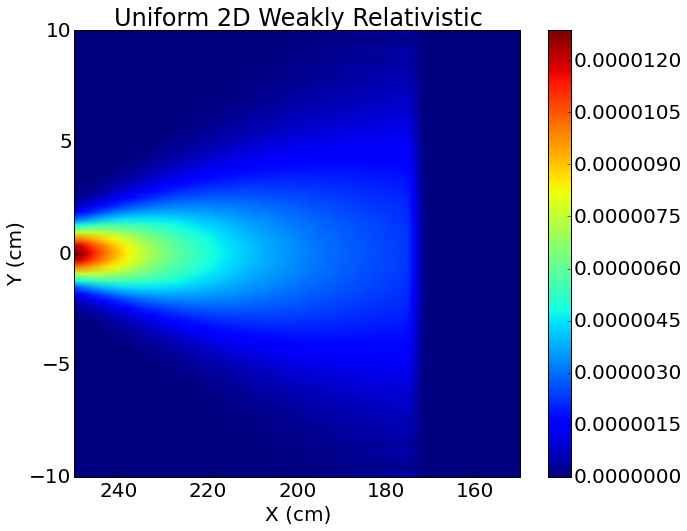

In [43]:
plt.figure()
plt.imshow(np.abs(E2_r_uni[nz/2, :, :]), extent=[x_start, x_end, y_min, y_max], origin='lower',
          aspect=np.abs((x_end-x_start)/(y_max-y_min)))
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.title('Uniform 2D Weakly Relativistic')
plt.colorbar()

In [44]:
abs_err = E2_r_uni - E1_r
rel_idx = np.abs(E1_r)>1e-3*np.max(np.abs(E1_r))
rel_err = abs_err[rel_idx]/np.abs(E1_r[rel_idx])
print('max |E|: {}\nmax absolute error: {}\nmax relative error: {}'.format(np.max(np.abs(E1_r)), 
                                                                           np.max(np.abs(abs_err)), 
                                                                           np.max(np.abs(rel_err))) )

max |E|: 1.28594805106e-05
max absolute error: 6.38829459389e-10
max relative error: 0.000459345525335


In [45]:
from FPSDP.scripts.unit_tests.test_Propagator import benchmark_1d2d
abs_err_r, rel_err_r, nx_array_r, x_stepsize_r = benchmark_1d2d(nx_power_min=3, nx_power_max=9, nx_step=1, mode='X', 
                                                        dielectric=dt.RelElectronColdIon, max_harmonic=2,
                                                       max_power=2)

Propagator 1D initialized.
Propagator 2D initialized.
Total time: 55.72s


In [46]:
from scipy.stats import linregress
slope_abs_r, intercept_abs_r, r_abs_r, p_abs_r, stderr_abs_r = linregress(np.log(x_stepsize_r), np.log(abs_err_r))
y_abs_r = np.exp(intercept_abs_r) * x_stepsize_r**slope_abs_r
slope_rel_r, intercept_rel_r, r_rel_r, p_rel_r, stderr_rel_r = linregress(np.log(x_stepsize_r), np.log(rel_err_r))
y_rel_r = np.exp(intercept_rel_r) * x_stepsize_r**slope_rel_r

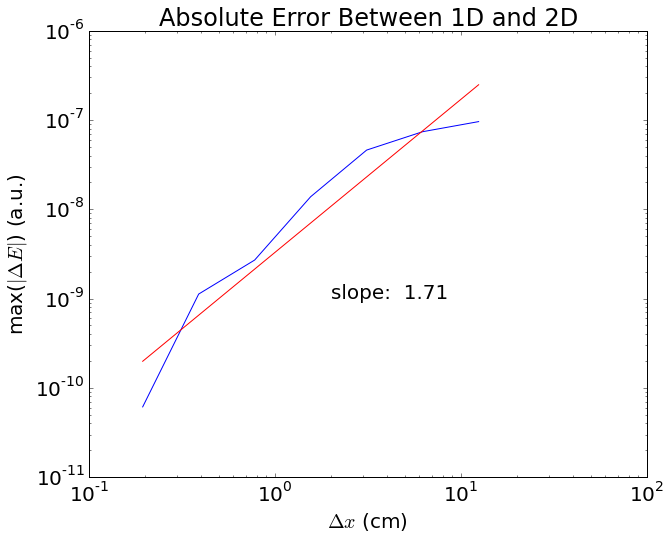

In [47]:
plt.figure()
plt.loglog(x_stepsize_r, abs_err_r)
plt.loglog(x_stepsize_r, y_abs_r, 'r-')
plt.xlabel('$\Delta x$ (cm)')
plt.ylabel('max($|\Delta E|$) (a.u.)')
plt.title('Absolute Error Between 1D and 2D')
plt.text(2, 1e-9, 'slope:  {:.3}'.format(slope_abs_r))